In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt


In [12]:

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define data transforms
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the directory path
data_dir = r"D:\archive (1)\PlantVillage"

# Load the entire dataset
full_dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)

# Define the sizes of each split
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

# Split the dataset into training, validation, and testing sets
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size, test_size])

# Create data loaders for each set
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

# Print class names
print(full_dataset.classes)

# Count number of images per class
class_counts = {class_name: 0 for class_name in full_dataset.classes}
for _, label in full_dataset.samples:
    class_name = full_dataset.classes[label]
    class_counts[class_name] += 1

print("Number of images per class:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")


['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
Number of images per class:
Pepper__bell___Bacterial_spot: 997
Pepper__bell___healthy: 1478
Potato___Early_blight: 1000
Potato___Late_blight: 1000
Potato___healthy: 152
Tomato_Bacterial_spot: 2127
Tomato_Early_blight: 1000
Tomato_Late_blight: 1909
Tomato_Leaf_Mold: 952
Tomato_Septoria_leaf_spot: 1771
Tomato_Spider_mites_Two_spotted_spider_mite: 1676
Tomato__Target_Spot: 1404
Tomato__Tomato_YellowLeaf__Curl_Virus: 3208
Tomato__Tomato_mosaic_virus: 373
Tomato_healthy: 1591


In [13]:

# Define custom modules and model
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=4):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1)
        self.fc2 = nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1)
    
    def forward(self, x):
        scale = torch.mean(x, (2, 3), keepdim=True)
        scale = nn.functional.relu(self.fc1(scale))
        scale = torch.sigmoid(self.fc2(scale))
        return x * scale

class GhostModule(nn.Module):
    def __init__(self, in_channels, out_channels, ratio=2, kernel_size=1, dw_kernel_size=3, stride=1, relu=True):
        super(GhostModule, self).__init__()
        self.out_channels = out_channels
        self.init_channels = int(out_channels / ratio)
        self.new_channels = self.init_channels * (ratio - 1)
        
        self.primary_conv = nn.Sequential(
            nn.Conv2d(in_channels, self.init_channels, kernel_size, stride, kernel_size//2, bias=False),
            nn.BatchNorm2d(self.init_channels),
            nn.ReLU(inplace=True) if relu else nn.Sequential()
        )
        
        self.cheap_operation = nn.Sequential(
            nn.Conv2d(self.init_channels, self.new_channels, dw_kernel_size, 1, dw_kernel_size//2, groups=self.init_channels, bias=False),
            nn.BatchNorm2d(self.new_channels),
            nn.ReLU(inplace=True) if relu else nn.Sequential()
        )
    
    def forward(self, x):
        x1 = self.primary_conv(x)
        x2 = self.cheap_operation(x1)
        out = torch.cat([x1, x2], dim=1)
        return out[:, :self.out_channels, :, :]

class GhostBottleneck(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, dw_kernel_size=3, stride=1, use_se=False):
        super(GhostBottleneck, self).__init__()
        self.stride = stride
        self.use_se = use_se

        self.ghost1 = GhostModule(in_channels, mid_channels, relu=True)
        self.depthwise = nn.Sequential(
            nn.Conv2d(mid_channels, mid_channels, dw_kernel_size, stride=stride, padding=dw_kernel_size//2, groups=mid_channels, bias=False),
            nn.BatchNorm2d(mid_channels)
        ) if stride == 2 else nn.Sequential()

        self.ghost2 = GhostModule(mid_channels, out_channels, relu=False)

        self.shortcut = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, dw_kernel_size, stride=stride, padding=dw_kernel_size//2, groups=in_channels, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels)
        ) if stride == 2 or in_channels != out_channels else nn.Sequential()
        
        self.se = SEBlock(mid_channels) if self.use_se else nn.Sequential()

    def forward(self, x):
        residual = self.shortcut(x)
        x = self.ghost1(x)
        x = self.depthwise(x)
        x = self.se(x)
        x = self.ghost2(x)
        x += residual
        return x

class GhostNetCustom(nn.Module):
    def __init__(self, num_classes=15):
        super(GhostNetCustom, self).__init__()
        self.conv_stem = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        
        self.blocks = nn.Sequential(
            GhostBottleneck(16, 16, 16, stride=1),
            GhostBottleneck(16, 48, 24, stride=2),
            GhostBottleneck(24, 72, 24, stride=1),
            GhostBottleneck(24, 72, 40, stride=2, use_se=True),
            GhostBottleneck(40, 120, 40, stride=1, use_se=True),
            GhostBottleneck(40, 240, 80, stride=2),
            GhostBottleneck(80, 200, 80, stride=1),
            GhostBottleneck(80, 184, 80, stride=1),
            GhostBottleneck(80, 480, 112, stride=1, use_se=True),
            GhostBottleneck(112, 672, 160, stride=2, use_se=True),
            GhostBottleneck(160, 960, 160, stride=1, use_se=True)
        )
        
        self.conv_head = nn.Conv2d(160, 960, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(960)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(960, num_classes)
    
    def forward(self, x):
        x = self.relu(self.bn1(self.conv_stem(x)))
        x = self.blocks(x)
        x = self.relu(self.bn2(self.conv_head(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Print the model architecture
model = GhostNetCustom(num_classes=15)
print(model)


GhostNetCustom(
  (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (blocks): Sequential(
    (0): GhostBottleneck(
      (ghost1): GhostModule(
        (primary_conv): Sequential(
          (0): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (cheap_operation): Sequential(
          (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
          (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (depthwise): Sequential()
      (ghost2): GhostModule(
        (primary_conv): Sequential(
          (0): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1)


Training with learning rate: 0.001


Epoch [1/50], Train Loss: 1.2415, Train Accuracy: 0.5932, Val Loss: 0.7479, Val Accuracy: 0.7533


Epoch [2/50], Train Loss: 0.4798, Train Accuracy: 0.8379, Val Loss: 0.5251, Val Accuracy: 0.8124


Epoch [3/50], Train Loss: 0.3078, Train Accuracy: 0.8949, Val Loss: 0.4165, Val Accuracy: 0.8585


Epoch [4/50], Train Loss: 0.2029, Train Accuracy: 0.9301, Val Loss: 0.4625, Val Accuracy: 0.8541


Epoch [5/50], Train Loss: 0.1592, Train Accuracy: 0.9450, Val Loss: 0.5907, Val Accuracy: 0.8333


Epoch [6/50], Train Loss: 0.1383, Train Accuracy: 0.9535, Val Loss: 0.5865, Val Accuracy: 0.8255


Epoch [7/50], Train Loss: 0.1023, Train Accuracy: 0.9646, Val Loss: 0.3500, Val Accuracy: 0.8817


Epoch [8/50], Train Loss: 0.0887, Train Accuracy: 0.9697, Val Loss: 0.5042, Val Accuracy: 0.8677


Epoch [9/50], Train Loss: 0.0832, Train Accuracy: 0.9710, Val Loss: 0.4780, Val Accuracy: 0.8643


Epoch [10/50], Train Loss: 0.0628, Train Accuracy: 0.9783, Val Loss: 0.3091, Val Accuracy: 0.9011


Epoch [11/50], Train Loss: 0.0679, Train Accuracy: 0.9780, Val Loss: 0.3523, Val Accuracy: 0.8953


Epoch [12/50], Train Loss: 0.0721, Train Accuracy: 0.9753, Val Loss: 0.4199, Val Accuracy: 0.8909


Epoch [13/50], Train Loss: 0.0463, Train Accuracy: 0.9838, Val Loss: 0.3298, Val Accuracy: 0.9031


Epoch [14/50], Train Loss: 0.0511, Train Accuracy: 0.9832, Val Loss: 0.5421, Val Accuracy: 0.8623


Epoch [15/50], Train Loss: 0.0484, Train Accuracy: 0.9835, Val Loss: 0.3920, Val Accuracy: 0.8924


Epoch [16/50], Train Loss: 0.0553, Train Accuracy: 0.9806, Val Loss: 0.3536, Val Accuracy: 0.9011


Epoch [17/50], Train Loss: 0.0536, Train Accuracy: 0.9826, Val Loss: 0.3266, Val Accuracy: 0.9001


Epoch [18/50], Train Loss: 0.0605, Train Accuracy: 0.9795, Val Loss: 0.4137, Val Accuracy: 0.8866


Epoch [19/50], Train Loss: 0.0215, Train Accuracy: 0.9938, Val Loss: 0.2712, Val Accuracy: 0.9244


Epoch [20/50], Train Loss: 0.0288, Train Accuracy: 0.9907, Val Loss: 0.3349, Val Accuracy: 0.9137


Epoch [21/50], Train Loss: 0.0454, Train Accuracy: 0.9846, Val Loss: 0.4184, Val Accuracy: 0.8914


Epoch [22/50], Train Loss: 0.0545, Train Accuracy: 0.9813, Val Loss: 0.3817, Val Accuracy: 0.8919


Epoch [23/50], Train Loss: 0.0440, Train Accuracy: 0.9847, Val Loss: 0.2677, Val Accuracy: 0.9307


Epoch [24/50], Train Loss: 0.0221, Train Accuracy: 0.9930, Val Loss: 0.3349, Val Accuracy: 0.9132


Epoch [25/50], Train Loss: 0.0420, Train Accuracy: 0.9856, Val Loss: 0.3114, Val Accuracy: 0.9127


Epoch [26/50], Train Loss: 0.0398, Train Accuracy: 0.9863, Val Loss: 0.4163, Val Accuracy: 0.8968


Epoch [27/50], Train Loss: 0.0426, Train Accuracy: 0.9850, Val Loss: 0.3790, Val Accuracy: 0.9006


Epoch [28/50], Train Loss: 0.0251, Train Accuracy: 0.9916, Val Loss: 0.2261, Val Accuracy: 0.9399


Epoch [29/50], Train Loss: 0.0222, Train Accuracy: 0.9925, Val Loss: 0.2943, Val Accuracy: 0.9258


Epoch [30/50], Train Loss: 0.0356, Train Accuracy: 0.9885, Val Loss: 0.3166, Val Accuracy: 0.9229


Epoch [31/50], Train Loss: 0.0305, Train Accuracy: 0.9893, Val Loss: 0.3569, Val Accuracy: 0.9127


Epoch [32/50], Train Loss: 0.0509, Train Accuracy: 0.9834, Val Loss: 0.3582, Val Accuracy: 0.9137


Epoch [33/50], Train Loss: 0.0320, Train Accuracy: 0.9898, Val Loss: 0.2677, Val Accuracy: 0.9268


Epoch [34/50], Train Loss: 0.0313, Train Accuracy: 0.9895, Val Loss: 0.3117, Val Accuracy: 0.9171


Epoch [35/50], Train Loss: 0.0335, Train Accuracy: 0.9890, Val Loss: 0.3789, Val Accuracy: 0.9055


Epoch [36/50], Train Loss: 0.0216, Train Accuracy: 0.9929, Val Loss: 0.2760, Val Accuracy: 0.9220


Epoch [37/50], Train Loss: 0.0240, Train Accuracy: 0.9919, Val Loss: 0.2831, Val Accuracy: 0.9234


Epoch [38/50], Train Loss: 0.0204, Train Accuracy: 0.9933, Val Loss: 0.3765, Val Accuracy: 0.9079


Epoch [39/50], Train Loss: 0.0351, Train Accuracy: 0.9876, Val Loss: 0.3137, Val Accuracy: 0.9224


Epoch [40/50], Train Loss: 0.0250, Train Accuracy: 0.9913, Val Loss: 0.2132, Val Accuracy: 0.9399


Epoch [41/50], Train Loss: 0.0203, Train Accuracy: 0.9927, Val Loss: 0.2561, Val Accuracy: 0.9292


Epoch [42/50], Train Loss: 0.0337, Train Accuracy: 0.9891, Val Loss: 0.5029, Val Accuracy: 0.8856


Epoch [43/50], Train Loss: 0.0338, Train Accuracy: 0.9879, Val Loss: 0.2821, Val Accuracy: 0.9278


Epoch [44/50], Train Loss: 0.0217, Train Accuracy: 0.9930, Val Loss: 0.3363, Val Accuracy: 0.9181


Epoch [45/50], Train Loss: 0.0164, Train Accuracy: 0.9947, Val Loss: 0.4022, Val Accuracy: 0.9089


Epoch [46/50], Train Loss: 0.0203, Train Accuracy: 0.9934, Val Loss: 0.2574, Val Accuracy: 0.9365


Epoch [47/50], Train Loss: 0.0310, Train Accuracy: 0.9893, Val Loss: 0.2432, Val Accuracy: 0.9394


Epoch [48/50], Train Loss: 0.0300, Train Accuracy: 0.9906, Val Loss: 0.3929, Val Accuracy: 0.9016


Epoch [49/50], Train Loss: 0.0334, Train Accuracy: 0.9887, Val Loss: 0.3367, Val Accuracy: 0.9210


Epoch [50/50], Train Loss: 0.0316, Train Accuracy: 0.9896, Val Loss: 0.3359, Val Accuracy: 0.9186
Test Loss: 0.3583, Test Accuracy: 0.9254

Training with learning rate: 0.0001


Epoch [1/50], Train Loss: 2.0986, Train Accuracy: 0.3367, Val Loss: 1.6290, Val Accuracy: 0.4629


Epoch [2/50], Train Loss: 1.3490, Train Accuracy: 0.5724, Val Loss: 1.1535, Val Accuracy: 0.6195


Epoch [3/50], Train Loss: 0.9606, Train Accuracy: 0.6919, Val Loss: 0.9161, Val Accuracy: 0.6927


Epoch [4/50], Train Loss: 0.7198, Train Accuracy: 0.7706, Val Loss: 0.7947, Val Accuracy: 0.7247


Epoch [5/50], Train Loss: 0.5269, Train Accuracy: 0.8387, Val Loss: 0.7199, Val Accuracy: 0.7620


Epoch [6/50], Train Loss: 0.3784, Train Accuracy: 0.8876, Val Loss: 0.6985, Val Accuracy: 0.7644


Epoch [7/50], Train Loss: 0.2580, Train Accuracy: 0.9316, Val Loss: 0.7141, Val Accuracy: 0.7654


Epoch [8/50], Train Loss: 0.1673, Train Accuracy: 0.9620, Val Loss: 0.7265, Val Accuracy: 0.7668


Epoch [9/50], Train Loss: 0.1110, Train Accuracy: 0.9790, Val Loss: 0.7402, Val Accuracy: 0.7635


Epoch [10/50], Train Loss: 0.0732, Train Accuracy: 0.9886, Val Loss: 0.7650, Val Accuracy: 0.7736


Epoch [11/50], Train Loss: 0.0510, Train Accuracy: 0.9925, Val Loss: 0.7790, Val Accuracy: 0.7698


Epoch [12/50], Train Loss: 0.0323, Train Accuracy: 0.9978, Val Loss: 0.7940, Val Accuracy: 0.7722


Epoch [13/50], Train Loss: 0.0276, Train Accuracy: 0.9969, Val Loss: 0.8228, Val Accuracy: 0.7746


Epoch [14/50], Train Loss: 0.0195, Train Accuracy: 0.9985, Val Loss: 0.8238, Val Accuracy: 0.7761


Epoch [15/50], Train Loss: 0.0169, Train Accuracy: 0.9987, Val Loss: 0.8483, Val Accuracy: 0.7717


Epoch [16/50], Train Loss: 0.0159, Train Accuracy: 0.9982, Val Loss: 0.8485, Val Accuracy: 0.7664


Epoch [17/50], Train Loss: 0.0135, Train Accuracy: 0.9988, Val Loss: 0.8657, Val Accuracy: 0.7702


Epoch [18/50], Train Loss: 0.0129, Train Accuracy: 0.9984, Val Loss: 0.8836, Val Accuracy: 0.7702


Epoch [19/50], Train Loss: 0.0108, Train Accuracy: 0.9991, Val Loss: 0.9089, Val Accuracy: 0.7746


Epoch [20/50], Train Loss: 0.0107, Train Accuracy: 0.9989, Val Loss: 0.9256, Val Accuracy: 0.7688


Epoch [21/50], Train Loss: 0.0130, Train Accuracy: 0.9979, Val Loss: 0.9272, Val Accuracy: 0.7639


Epoch [22/50], Train Loss: 0.0134, Train Accuracy: 0.9976, Val Loss: 0.9672, Val Accuracy: 0.7664


Epoch [23/50], Train Loss: 0.0121, Train Accuracy: 0.9981, Val Loss: 0.9991, Val Accuracy: 0.7538


Epoch [24/50], Train Loss: 0.0109, Train Accuracy: 0.9986, Val Loss: 0.9753, Val Accuracy: 0.7678


Epoch [25/50], Train Loss: 0.0133, Train Accuracy: 0.9972, Val Loss: 0.9504, Val Accuracy: 0.7761


Epoch [26/50], Train Loss: 0.0182, Train Accuracy: 0.9957, Val Loss: 1.0026, Val Accuracy: 0.7610


Epoch [27/50], Train Loss: 0.0136, Train Accuracy: 0.9974, Val Loss: 1.0042, Val Accuracy: 0.7683


Epoch [28/50], Train Loss: 0.0126, Train Accuracy: 0.9973, Val Loss: 0.9782, Val Accuracy: 0.7765


Epoch 29/50:  53%|█████▎    | 68/129 [00:18<00:09,  6.47it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x00000280869072E0>
Traceback (most recent call last):
  File "c:\Users\user\anaconda3\envs\csir\Lib\site-packages\torch\utils\data\dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "c:\Users\user\anaconda3\envs\csir\Lib\site-packages\torch\utils\data\dataloader.py", line 1436, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
                                   ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


Epoch [29/50], Train Loss: 0.0112, Train Accuracy: 0.9975, Val Loss: 1.0356, Val Accuracy: 0.7698


Epoch [30/50], Train Loss: 0.0133, Train Accuracy: 0.9966, Val Loss: 1.0181, Val Accuracy: 0.7731


Epoch [31/50], Train Loss: 0.0129, Train Accuracy: 0.9969, Val Loss: 1.0486, Val Accuracy: 0.7702


Epoch [32/50], Train Loss: 0.0128, Train Accuracy: 0.9966, Val Loss: 1.0193, Val Accuracy: 0.7717


Epoch [33/50], Train Loss: 0.0114, Train Accuracy: 0.9971, Val Loss: 0.9964, Val Accuracy: 0.7882


Epoch [34/50], Train Loss: 0.0107, Train Accuracy: 0.9972, Val Loss: 1.0207, Val Accuracy: 0.7794


Epoch [35/50], Train Loss: 0.0110, Train Accuracy: 0.9972, Val Loss: 1.0717, Val Accuracy: 0.7857


Epoch [36/50], Train Loss: 0.0214, Train Accuracy: 0.9939, Val Loss: 1.0951, Val Accuracy: 0.7814


Epoch [37/50], Train Loss: 0.0115, Train Accuracy: 0.9964, Val Loss: 1.0702, Val Accuracy: 0.7741


Epoch [38/50], Train Loss: 0.0113, Train Accuracy: 0.9967, Val Loss: 1.0424, Val Accuracy: 0.7911


Epoch [39/50], Train Loss: 0.0100, Train Accuracy: 0.9974, Val Loss: 1.0408, Val Accuracy: 0.7891


Epoch [40/50], Train Loss: 0.0073, Train Accuracy: 0.9984, Val Loss: 1.0581, Val Accuracy: 0.7887


Epoch [41/50], Train Loss: 0.0053, Train Accuracy: 0.9987, Val Loss: 1.0252, Val Accuracy: 0.7916


Epoch [42/50], Train Loss: 0.0040, Train Accuracy: 0.9993, Val Loss: 1.0166, Val Accuracy: 0.7925


Epoch [43/50], Train Loss: 0.0034, Train Accuracy: 0.9997, Val Loss: 1.0386, Val Accuracy: 0.7959


Epoch [44/50], Train Loss: 0.0041, Train Accuracy: 0.9992, Val Loss: 1.0296, Val Accuracy: 0.7954


Epoch [45/50], Train Loss: 0.0049, Train Accuracy: 0.9988, Val Loss: 1.1715, Val Accuracy: 0.7799


Epoch [46/50], Train Loss: 0.0127, Train Accuracy: 0.9961, Val Loss: 1.1622, Val Accuracy: 0.7862


Epoch [47/50], Train Loss: 0.0108, Train Accuracy: 0.9975, Val Loss: 1.1199, Val Accuracy: 0.7838


Epoch [48/50], Train Loss: 0.0102, Train Accuracy: 0.9970, Val Loss: 1.1224, Val Accuracy: 0.7930


Epoch [49/50], Train Loss: 0.0153, Train Accuracy: 0.9952, Val Loss: 1.1626, Val Accuracy: 0.7799


Epoch [50/50], Train Loss: 0.0163, Train Accuracy: 0.9945, Val Loss: 1.1971, Val Accuracy: 0.7727
Test Loss: 1.3244, Test Accuracy: 0.7724

Training with learning rate: 1e-05


Epoch [1/50], Train Loss: 2.6382, Train Accuracy: 0.1281, Val Loss: 2.5457, Val Accuracy: 0.1949


Epoch [2/50], Train Loss: 2.4651, Train Accuracy: 0.2317, Val Loss: 2.3995, Val Accuracy: 0.2622


Epoch [3/50], Train Loss: 2.3248, Train Accuracy: 0.2688, Val Loss: 2.2718, Val Accuracy: 0.2850


Epoch [4/50], Train Loss: 2.1826, Train Accuracy: 0.3124, Val Loss: 2.1247, Val Accuracy: 0.3393


Epoch [5/50], Train Loss: 2.0335, Train Accuracy: 0.3721, Val Loss: 1.9895, Val Accuracy: 0.3912


Epoch [6/50], Train Loss: 1.9003, Train Accuracy: 0.4121, Val Loss: 1.8700, Val Accuracy: 0.4329


Epoch [7/50], Train Loss: 1.7865, Train Accuracy: 0.4503, Val Loss: 1.7722, Val Accuracy: 0.4600


Epoch [8/50], Train Loss: 1.6861, Train Accuracy: 0.4819, Val Loss: 1.6847, Val Accuracy: 0.4886


Epoch [9/50], Train Loss: 1.6001, Train Accuracy: 0.5068, Val Loss: 1.6076, Val Accuracy: 0.5085


Epoch [10/50], Train Loss: 1.5218, Train Accuracy: 0.5291, Val Loss: 1.5401, Val Accuracy: 0.5254


Epoch [11/50], Train Loss: 1.4478, Train Accuracy: 0.5465, Val Loss: 1.4808, Val Accuracy: 0.5381


Epoch [12/50], Train Loss: 1.3805, Train Accuracy: 0.5711, Val Loss: 1.4230, Val Accuracy: 0.5536


Epoch [13/50], Train Loss: 1.3164, Train Accuracy: 0.5869, Val Loss: 1.3732, Val Accuracy: 0.5633


Epoch [14/50], Train Loss: 1.2575, Train Accuracy: 0.6064, Val Loss: 1.3254, Val Accuracy: 0.5768


Epoch [15/50], Train Loss: 1.2065, Train Accuracy: 0.6236, Val Loss: 1.2818, Val Accuracy: 0.5919


Epoch [16/50], Train Loss: 1.1528, Train Accuracy: 0.6400, Val Loss: 1.2479, Val Accuracy: 0.6040


Epoch [17/50], Train Loss: 1.1099, Train Accuracy: 0.6534, Val Loss: 1.2154, Val Accuracy: 0.6098


Epoch [18/50], Train Loss: 1.0606, Train Accuracy: 0.6708, Val Loss: 1.1743, Val Accuracy: 0.6214


Epoch [19/50], Train Loss: 1.0187, Train Accuracy: 0.6838, Val Loss: 1.1487, Val Accuracy: 0.6292


Epoch [20/50], Train Loss: 0.9788, Train Accuracy: 0.6967, Val Loss: 1.1191, Val Accuracy: 0.6423


Epoch [21/50], Train Loss: 0.9378, Train Accuracy: 0.7099, Val Loss: 1.0936, Val Accuracy: 0.6491


Epoch [22/50], Train Loss: 0.9017, Train Accuracy: 0.7197, Val Loss: 1.0704, Val Accuracy: 0.6510


Epoch [23/50], Train Loss: 0.8681, Train Accuracy: 0.7334, Val Loss: 1.0525, Val Accuracy: 0.6534


Epoch [24/50], Train Loss: 0.8328, Train Accuracy: 0.7455, Val Loss: 1.0294, Val Accuracy: 0.6607


Epoch [25/50], Train Loss: 0.8007, Train Accuracy: 0.7560, Val Loss: 1.0085, Val Accuracy: 0.6684


Epoch [26/50], Train Loss: 0.7728, Train Accuracy: 0.7648, Val Loss: 0.9987, Val Accuracy: 0.6680


Epoch [27/50], Train Loss: 0.7436, Train Accuracy: 0.7762, Val Loss: 0.9792, Val Accuracy: 0.6772


Epoch [28/50], Train Loss: 0.7129, Train Accuracy: 0.7848, Val Loss: 0.9670, Val Accuracy: 0.6883


Epoch [29/50], Train Loss: 0.6851, Train Accuracy: 0.7935, Val Loss: 0.9534, Val Accuracy: 0.6907


Epoch [30/50], Train Loss: 0.6587, Train Accuracy: 0.8016, Val Loss: 0.9433, Val Accuracy: 0.6917


Epoch [31/50], Train Loss: 0.6265, Train Accuracy: 0.8151, Val Loss: 0.9339, Val Accuracy: 0.6966


Epoch [32/50], Train Loss: 0.6010, Train Accuracy: 0.8193, Val Loss: 0.9225, Val Accuracy: 0.7004


Epoch [33/50], Train Loss: 0.5785, Train Accuracy: 0.8303, Val Loss: 0.9161, Val Accuracy: 0.6990


Epoch [34/50], Train Loss: 0.5552, Train Accuracy: 0.8370, Val Loss: 0.9048, Val Accuracy: 0.7058


Epoch [35/50], Train Loss: 0.5309, Train Accuracy: 0.8457, Val Loss: 0.8991, Val Accuracy: 0.7063


Epoch [36/50], Train Loss: 0.5080, Train Accuracy: 0.8557, Val Loss: 0.8932, Val Accuracy: 0.7063


Epoch [37/50], Train Loss: 0.4851, Train Accuracy: 0.8629, Val Loss: 0.8901, Val Accuracy: 0.7024


Epoch [38/50], Train Loss: 0.4672, Train Accuracy: 0.8658, Val Loss: 0.8886, Val Accuracy: 0.7063


Epoch [39/50], Train Loss: 0.4441, Train Accuracy: 0.8743, Val Loss: 0.8795, Val Accuracy: 0.7077


Epoch [40/50], Train Loss: 0.4255, Train Accuracy: 0.8804, Val Loss: 0.8841, Val Accuracy: 0.7058


Epoch [41/50], Train Loss: 0.4053, Train Accuracy: 0.8892, Val Loss: 0.8818, Val Accuracy: 0.7058


Epoch [42/50], Train Loss: 0.3863, Train Accuracy: 0.8965, Val Loss: 0.8839, Val Accuracy: 0.7092


Epoch [43/50], Train Loss: 0.3635, Train Accuracy: 0.9059, Val Loss: 0.8774, Val Accuracy: 0.7063


Epoch [44/50], Train Loss: 0.3524, Train Accuracy: 0.9058, Val Loss: 0.8821, Val Accuracy: 0.7082


Epoch [45/50], Train Loss: 0.3318, Train Accuracy: 0.9153, Val Loss: 0.8871, Val Accuracy: 0.7058


Epoch [46/50], Train Loss: 0.3125, Train Accuracy: 0.9231, Val Loss: 0.8807, Val Accuracy: 0.7111


Epoch [47/50], Train Loss: 0.2971, Train Accuracy: 0.9277, Val Loss: 0.8822, Val Accuracy: 0.7126


Epoch [48/50], Train Loss: 0.2817, Train Accuracy: 0.9323, Val Loss: 0.8879, Val Accuracy: 0.7087


Epoch [49/50], Train Loss: 0.2679, Train Accuracy: 0.9373, Val Loss: 0.8923, Val Accuracy: 0.7111


Epoch [50/50], Train Loss: 0.2537, Train Accuracy: 0.9408, Val Loss: 0.8887, Val Accuracy: 0.7111
Test Loss: 0.8801, Test Accuracy: 0.7211


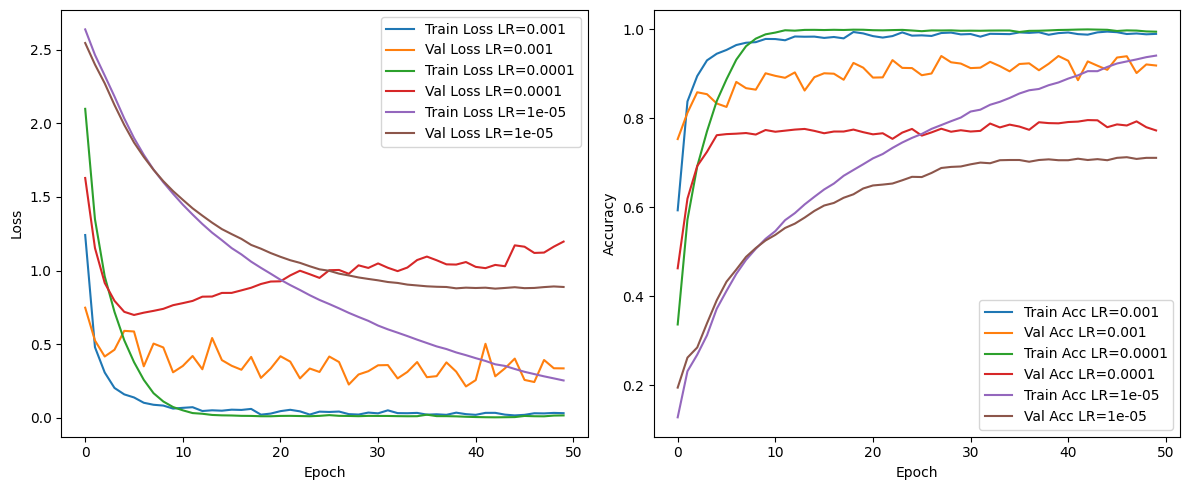

In [14]:

# Define the evaluation function
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_loss = loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy

# Define the training and evaluation function
def train_and_evaluate_model(model, train_loader, val_loader, test_loader, criterion, num_epochs, lr, device):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)
        
        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
    
    test_loss, test_accuracy = evaluate_model(model, test_loader, criterion, device)
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
    
    return train_losses, val_losses, train_accuracies, val_accuracies

# Define the learning rates to evaluate
learning_rates = [1e-3, 1e-4, 1e-5]

# Initialize the model and criterion
model = GhostNetCustom().to(device)
criterion = nn.CrossEntropyLoss()

# Loop through learning rates
results = {}
for lr in learning_rates:
    print(f'\nTraining with learning rate: {lr}')
    model = GhostNetCustom().to(device)
    train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate_model(model, train_loader, val_loader, test_loader, criterion, num_epochs=50, lr=lr, device=device)
    results[lr] = (train_losses, val_losses, train_accuracies, val_accuracies)

# Plot the results
plt.figure(figsize=(12, 5))

for lr, (train_losses, val_losses, train_accuracies, val_accuracies) in results.items():
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label=f'Train Loss LR={lr}')
    plt.plot(val_losses, label=f'Val Loss LR={lr}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label=f'Train Acc LR={lr}')
    plt.plot(val_accuracies, label=f'Val Acc LR={lr}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()
